In [14]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as scs
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
%config InlineBackend.figure_format = 'retina'

In [2]:
data_filename = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"#"data/us-states.csv"

df = pd.read_csv(data_filename)
df["date"] = pd.to_datetime(df["date"])

In [3]:
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [4]:
state_pop_df = pd.read_csv("data/state_pop.csv", skiprows=1)
state_pop_df["fips"] = state_pop_df["id"].str[-2:].astype(int)

In [5]:
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [10]:
TEST_LAG = 8
DEATH_LAG = 18
DETECTION_PROB = 1/8
DEATH_PROB = 1/50
STATE_FIPS = 53

CASES_MIN = 300
DEATH_MIN = 10
TEST_TRUSTWORTHY_START = 50
DEATH_TRUSTWORTHY_START = 46

df_state = df[df.state=="Washington"]

date0 = df_state.iloc[0].date

case_plot = df_state[ df_state.cases >= CASES_MIN ]
death_plot = df_state[ df_state.deaths >= DEATH_MIN ]

test_day = (case_plot.date-date0).dt.days-TEST_LAG
test_results = case_plot.cases/DETECTION_PROB

death_day = (death_plot.date-date0).dt.days-DEATH_LAG
death_results = death_plot.deaths/DEATH_PROB

(1, 1000000)

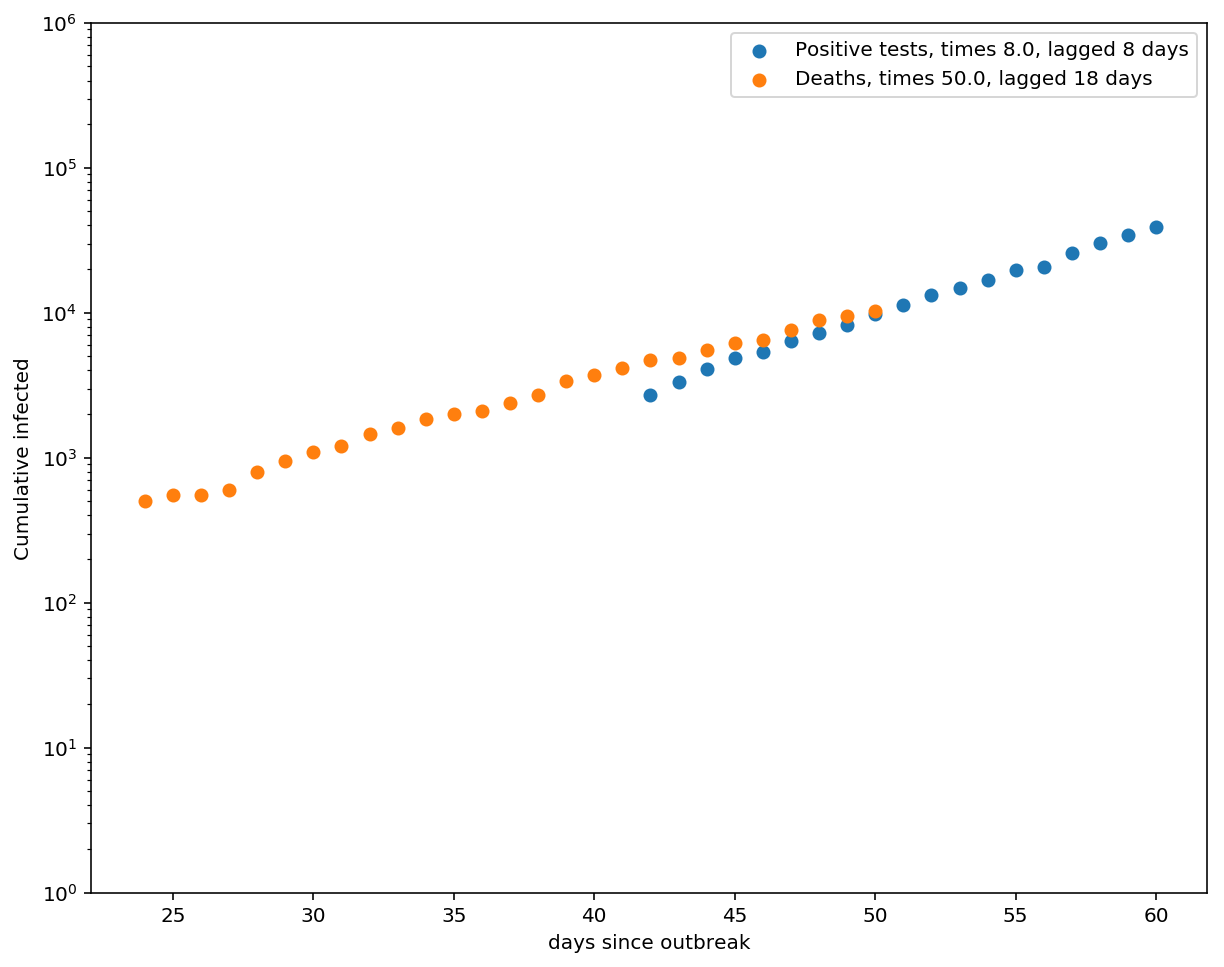

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter( test_day, test_results, label="Positive tests, times %s, lagged %s days"%(1/DETECTION_PROB, TEST_LAG) )
ax.scatter( death_day, death_results, label="Deaths, times %s, lagged %s days"%(1/DEATH_PROB, DEATH_LAG) )
ax.set_xlabel("days since outbreak")
ax.set_ylabel("Cumulative infected")
ax.legend()
ax.semilogy()
ax.set_ylim(1,1000000)

In [7]:
day = np.concatenate( [test_day, death_day] )
result = np.concatenate( [test_results, death_results] )

In [8]:
X = sm.add_constant(day)
y = np.log(result)

In [9]:
mod = sm.OLS(y, X)
res = mod.fit()

In [10]:
res.params

array([7.41270531, 0.30705522])

In [11]:
res.conf_int(alpha=0.05)

array([[7.20067863, 7.62473199],
       [0.28606146, 0.32804899]])

In [12]:
res.cov_params()

array([[ 0.01077838, -0.00084536],
       [-0.00084536,  0.00010567]])

In [13]:
norm = scs.multivariate_normal(mean=res.params, cov=res.cov_params())

In [14]:
norm.rvs(10)

array([[7.58625835, 0.3007579 ],
       [7.44625559, 0.30882528],
       [7.44599292, 0.30519207],
       [7.45147572, 0.31224712],
       [7.29711533, 0.31631245],
       [7.24628452, 0.3219774 ],
       [7.26664499, 0.31017549],
       [7.37588964, 0.30234844],
       [7.40186829, 0.31128203],
       [7.4770503 , 0.30413816]])

In [15]:
foo = [1,2,3,4]
np.vstack((np.ones_like(foo),foo)).T

array([[1, 1],
       [1, 2],
       [1, 3],
       [1, 4]])

In [16]:
def add_one(ary):
    """Input: 1-d array
    Output: 2d array, 0th column all 1s."""
    
    return np.vstack((np.ones_like(ary),ary)).T

class LoglinearModel:
        
    def fit(self, x, y):
        X = sm.add_constant(x)
        
        mod = sm.OLS(np.log(y), X)
        res = mod.fit()
        
        self.params = res.params
        self.cov = res.cov_params()
    
    def __call__(self, x):
        return np.exp(add_one(x) @ self.params )
    
    def sample(self, x, n_samples=100):
        norm = scs.multivariate_normal(mean=self.params, cov=self.cov)
        param_samples = norm.rvs(n_samples)
        
        return np.exp(add_one(x) @ param_samples.T).flatten()

In [22]:
today_days = (pd.to_datetime( datetime.today() ) - date0).days
today_days

29

In [24]:
infection_pred(today_days)

array([12204396.60724169])

In [25]:
infection_pred = LoglinearModel()
infection_pred.fit( day, result )

(array([ 10.,  16.,  74., 173., 300., 385., 528., 558., 560., 516., 495.,
        398., 277., 234., 152., 119.,  81.,  49.,  26.,  15.,  13.,   5.,
          4.,   5.,   2.,   2.,   2.,   0.,   0.,   1.]),
 array([ 5257641.96476628,  6043039.37224386,  6828436.77972143,
         7613834.18719901,  8399231.59467658,  9184629.00215416,
         9970026.40963173, 10755423.81710931, 11540821.22458688,
        12326218.63206445, 13111616.03954203, 13897013.4470196 ,
        14682410.85449718, 15467808.26197475, 16253205.66945232,
        17038603.0769299 , 17824000.48440747, 18609397.89188505,
        19394795.29936262, 20180192.70684019, 20965590.11431777,
        21750987.52179535, 22536384.92927292, 23321782.33675049,
        24107179.74422807, 24892577.15170565, 25677974.55918322,
        26463371.96666079, 27248769.37413836, 28034166.78161594,
        28819564.18909351]),
 <a list of 30 Patch objects>)

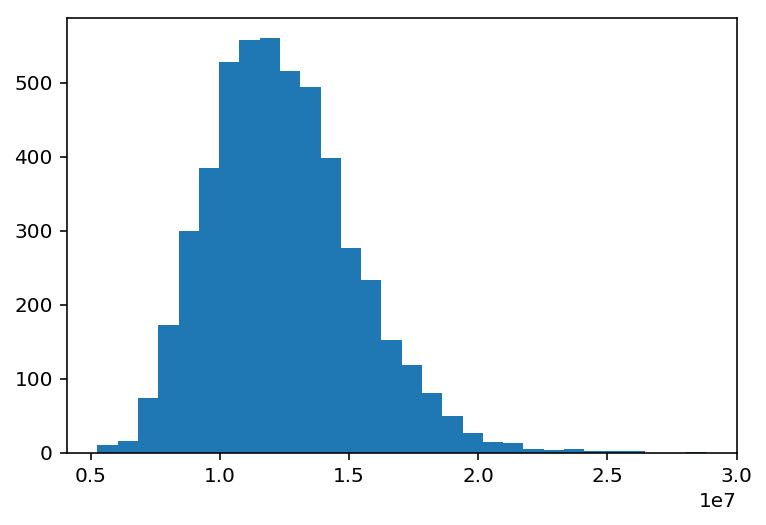

In [26]:
plt.hist( infection_pred.sample(today_days, n_samples=5000), bins=30 )

In [40]:
dayspace = np.arange(0,80)


[]

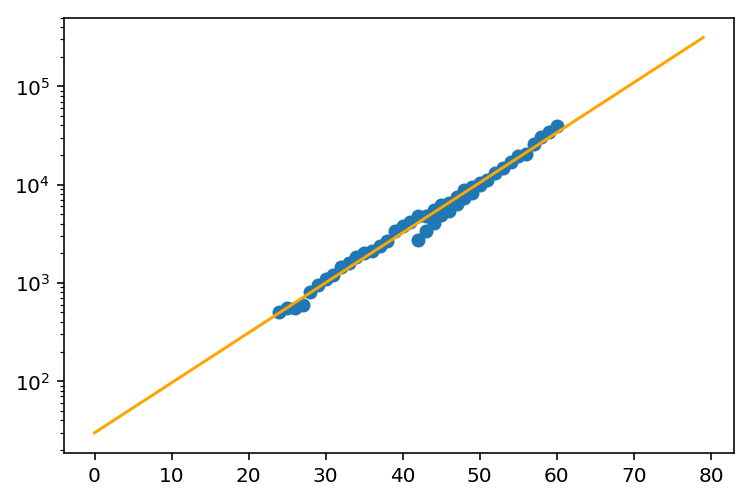

In [41]:
plt.scatter( day, result )
plt.plot( dayspace, infection_pred(dayspace), c="orange" )
plt.semilogy()

In [42]:
today_days = (pd.to_datetime( datetime.today() ) - day0).days

NameError: name 'day0' is not defined

In [ ]:
infection_pred( today_days )